In [62]:
import pandas as pd
import numpy as np
import cv2
import os
import shutil
from PIL import Image as img
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt


In [52]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [53]:
print(os.listdir("../CatsvsDogscode"))
path = "../CatsvsDogscode/dogs-vs-cats/train/"
print(os.listdir(path))


['.git', '.ipynb_checkpoints', '11T.4A188jojJiyhHVBFZZlg.jpeg', 'dogs-vs-cats', 'DogsvsCats.ipynb']
['Cat', 'Dog']


In [59]:
counter = 0
for filename in os.listdir(path):
    newfile = os.path.join(path, filename.replace(".","_",1))
    shutil.move(os.path.join(path,filename),newfile)
    counter+=1
    if counter % 1000 ==0:
        print(counter,"Images Renamed")


1000 Images Renamed
2000 Images Renamed
3000 Images Renamed
4000 Images Renamed
5000 Images Renamed
6000 Images Renamed
7000 Images Renamed
8000 Images Renamed
9000 Images Renamed
10000 Images Renamed
11000 Images Renamed
12000 Images Renamed
13000 Images Renamed
14000 Images Renamed
15000 Images Renamed
16000 Images Renamed
17000 Images Renamed
18000 Images Renamed
19000 Images Renamed
20000 Images Renamed
21000 Images Renamed
22000 Images Renamed
23000 Images Renamed
24000 Images Renamed
25000 Images Renamed


In [60]:
#counter = 0
#for filename in os.listdir(path):
#    os.rename(path+filename,filename.replace("_",".",1))
#    counter+=1
#    if counter % 1000 ==0:
#        print(counter,"Images Renamed")
#Not working neatly. It takes the files renames and then move to the main folder.        


In [4]:
'''from matplotlib import pyplot as plt
for p in os.listdir(path):
    category = p.split(".")[-1]
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(64, 64))
    plt.imshow(new_img_array)
    break'''

'from matplotlib import pyplot as plt\nfor p in os.listdir(path):\n    category = p.split(".")[-1]\n    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)\n    new_img_array = cv2.resize(img_array, dsize=(64, 64))\n    plt.imshow(new_img_array)\n    break'

In [54]:
train_data_path = "../CatsvsDogscode/dogs-vs-cats/train/"


In [55]:
from torch.utils.data import DataLoader, Sampler
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.405],
                         std=[0.229, 0.224, 0.225])
])

dc_dataset = datasets.ImageFolder(train_data_path,
                                  transform=data_transform)

train_loader = DataLoader(dataset=dc_dataset, batch_size=20, shuffle=True, num_workers=5)

In [56]:
print(dc_dataset.class_to_idx)

{'Cat': 0, 'Dog': 1}


In [57]:
def imshow(img):
    img = img / 2 +0.5
    plt.imshow(np.transpose(img[0].numpy(), (1, 2, 0)))
    plt.show()
    

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


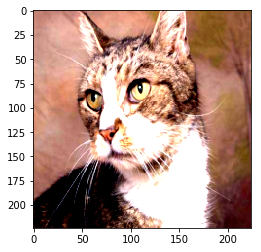

In [68]:

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)
# show images
imshow(images)


In [69]:
# CNN Model for Image Classification